In [324]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display
import math
%matplotlib inline

In [202]:
# Quadratic equation from calculus, 3x^2 - 4x +5
def f(x):
  return 3*x**2 - 4*x + 5

In [203]:
# Substituting x with 3

f(3.0)

20.0

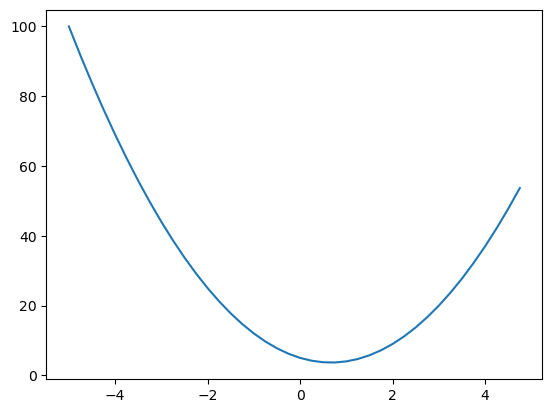

In [204]:
# Supplying a numpy array of numbers as x and ploting the result

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

## Derivatives

In [206]:
# Calculating derivative at a point x of the above ploted function
# Formular is sumarized in the below link
# https://wikimedia.org/api/rest_v1/media/math/render/svg/aae79a56cdcbc44af1612a50f06169b07f02cbf3
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [207]:
# d is a 3-scalar function
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [208]:
# Derivative of d with respect to a
# Bump a by a very small margin
h = 0.000001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.9999969999999996
slope -3.000000000419334


In [209]:
# Derivative of d with respect to b
d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 3.9999969999999996
d2 3.999999000001
slope 2.0000010003684565


In [210]:
# Derivative of d with respect to c
d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 3.999999000001
d2 4.000000000000999
slope 0.9999999992515995


## Neural Networks

In [414]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)

        out = Value(t, (self, ), _op='tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out
        
    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), '-')

In [213]:
a = Value(2)
a

Value(data=2)

In [214]:
b = Value(3)
b

Value(data=3)

In [215]:
b + a

Value(data=5)

In [216]:
b * a

Value(data=6)

In [217]:
b - a

Value(data=1)

In [218]:
# Reproduce the equation a*b + c wrapping each value with our Value class
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')
e = a*b; e.label='e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L


Value(data=-8.0)

In [219]:
d._prev

{Value(data=-6), Value(data=10)}

In [220]:
d._op

'+'

In [221]:
d.label

'd'

### Creating a function that visualizes root nodes using graphviz

In [223]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return display(dot)

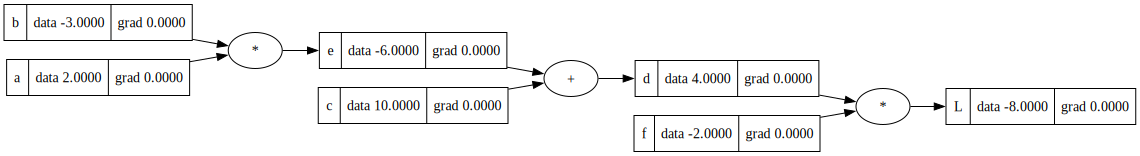

In [224]:
draw_dot(L)

## Calculating the derivatives of each variable with respect to L

In [226]:
def lol():
    h = 0.0000001
    a = Value(2, label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2, label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data + h

    print((L2 - L1)/h)

lol()

1.0000000028043132


In [227]:
### Manual back propagation
L.grad = 1

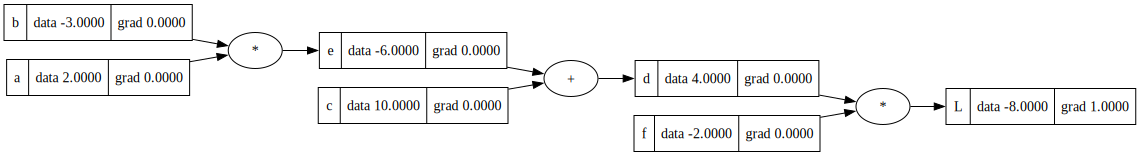

In [228]:
draw_dot(L)

L = d * f
dL/dd =? f

Below formula is defination of a derivative

(f(x+h) - f(x))/h (make d x)

((d+h)*f - d*f)/h

(d*f + h*f - d*f)/h

(h*f)/h == f

In [230]:
# Based on the above math:
## Derivative of L with respect to d == value of f
## Derivative of L with respect to f == value of d
f.grad = 4
d.grad = -2

In [231]:
def lol():
    h = 0.00001
    a = Value(2, label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2, label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0 + h, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

4.000000000026205


In [232]:
def lol():
    h = 0.001
    a = Value(2, label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2, label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label = 'd'
    d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-2.000000000000668


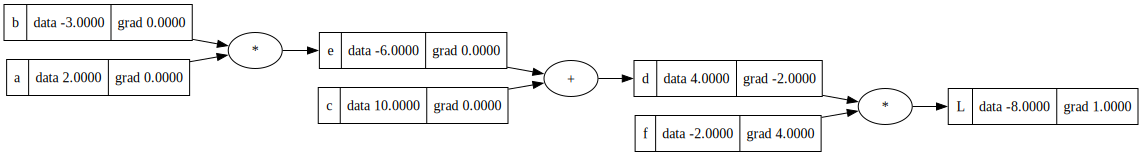

In [233]:
draw_dot(L)

dL / dc?
dd / dc
d = c + e

Defination of a derivative

(f(x+h) - f(x))/h

((c + h + e) - (c+e))/h

(c + h + e - c - e)/h

(h)/h == 1

Chain rule from calculus

(dz/dx) == (dz/dy) * (dy/dx)

WANT:
dL / dc == (dL / dd) * (dd / dc)

KNOW:
dL / dd,
dd / dc,
dd / dc will equal 1

In [236]:
c.grad = -2.0 * 1
e.grad = -2.0 * 1

In [237]:
def lol():
    h = 0.001
    a = Value(2, label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2, label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c'); c.data += h
    e = a*b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-1.9999999999988916


In [238]:
def lol():
    h = 0.001
    a = Value(2, label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2, label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'; e.data += h
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-2.000000000000668


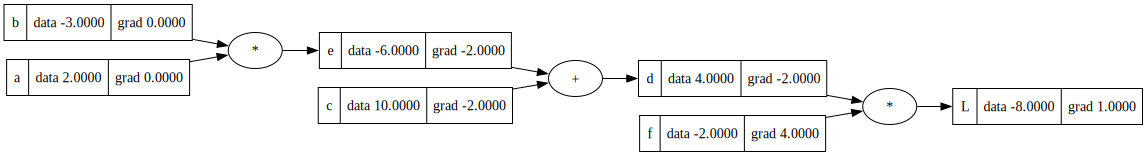

In [239]:
draw_dot(L)

Second application of chain rule

dL / de == -2.0

dL / da == (dL / de) * (de / da)

e = a * b

de / da ? b

(f(x+h) - f(x))/h

((a*b + h) - a*b)/h

(a*b - a*b + h)/h

(h)/h == 1

In [241]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [242]:
def lol():
    h = 0.001
    a = Value(2, label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2, label='a'); a.data += h
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

6.000000000000227


In [243]:
def lol():
    h = 0.00001
    a = Value(2, label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2, label='a')
    b = Value(-3, label='b'); b.data += h
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-4.000000000026205


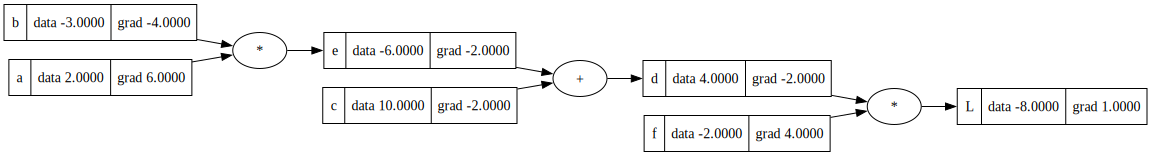

In [244]:
draw_dot(L)

In [245]:
# Reset the value of each variable with small steps in the direction of the gradient after back propergation
step = 0.01
a.data += step * a.grad
b.data += step * b.grad
c.data += step * c.grad
e.data += step * e.grad
f.data += step * f.grad

In [246]:
# Redo forward pass
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
L = f * d; L.label = 'L'

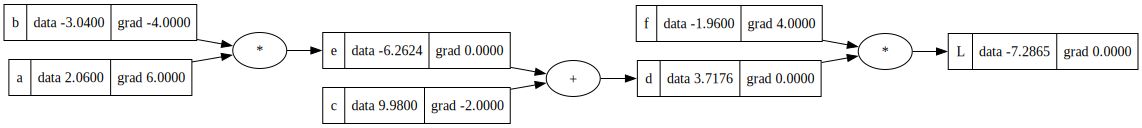

In [247]:
draw_dot(L)

## Example of an activation function

In [315]:
plt.plot(np.arange(-5,5,.2), np.tanh(np.arange(-5,5,.2))); plt.grid()

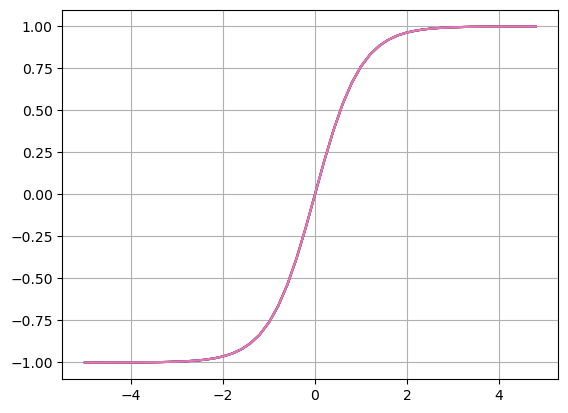

In [317]:
plt.show()

## A simple neural network

In [358]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias pf the neuron
b = Value(6.7, label='b')

# Calculate x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

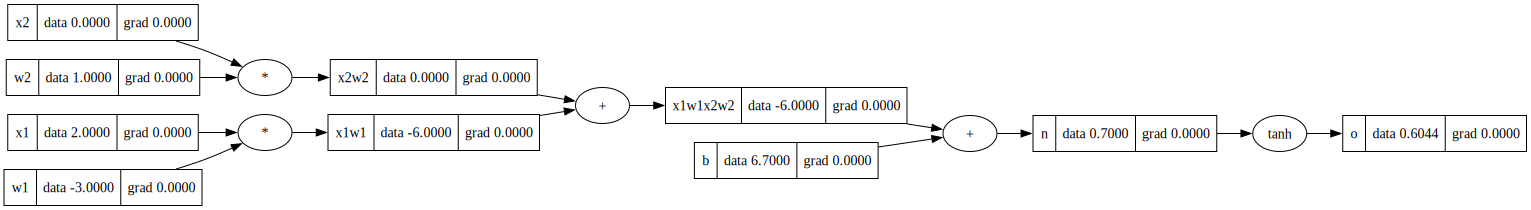

In [360]:
draw_dot(o)

In [383]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias pf the neuron
b = Value(6.8813735870195432, label='b')

# Calculate x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

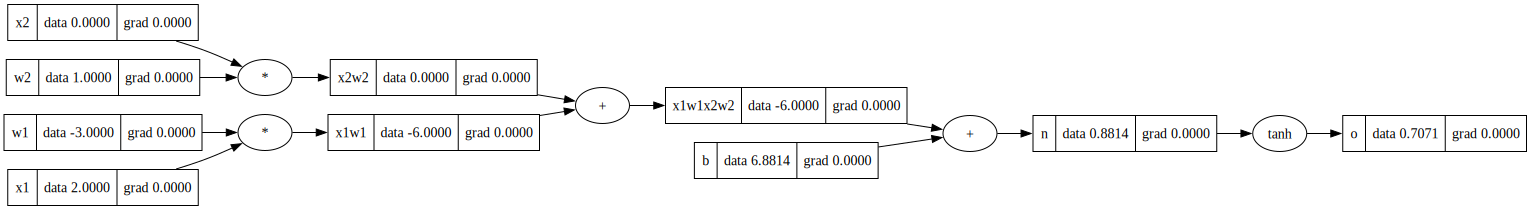

In [385]:
draw_dot(o)

In [386]:
o.grad = 1

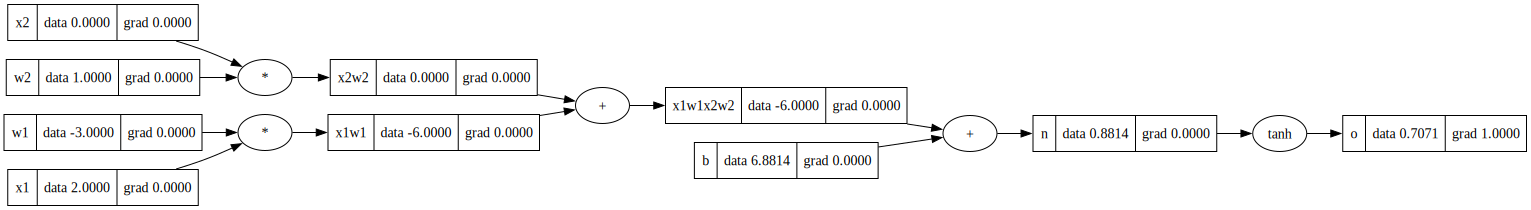

In [389]:
draw_dot(o)

do / dn = 1 - tanh(n)^2

tanh(n) == o

do/dn = 1 - o**2

In [392]:
1 - o.data**2

0.4999999999999999

In [394]:
n.grad = 0.5

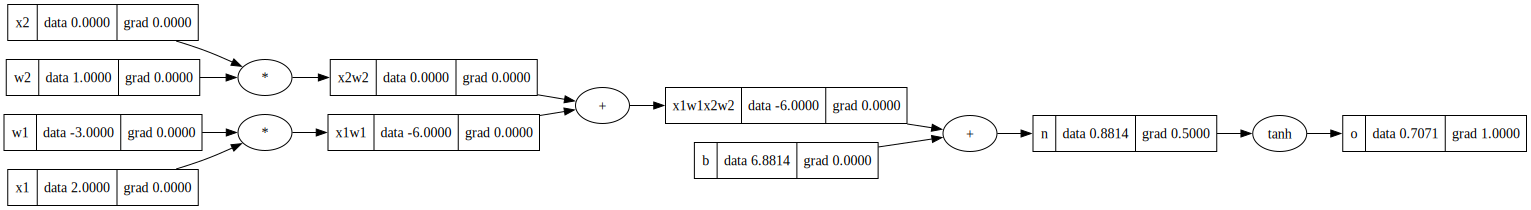

In [396]:
draw_dot(o)

In [398]:
x1w1x2w2.grad = 0.5
b.grad = .5

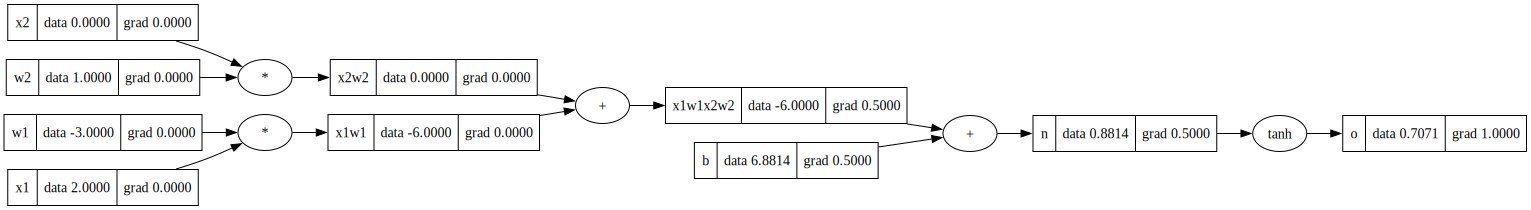

In [400]:
draw_dot(o)

In [402]:
x1w1.grad = 0.5
x2w2.grad = 0.5

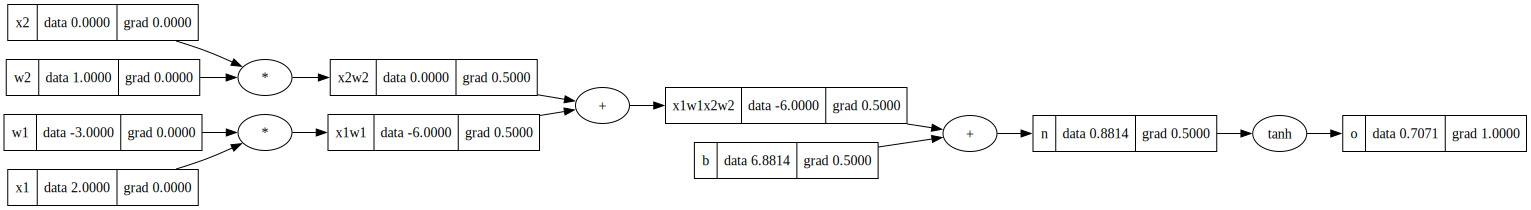

In [404]:
draw_dot(o)

In [406]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

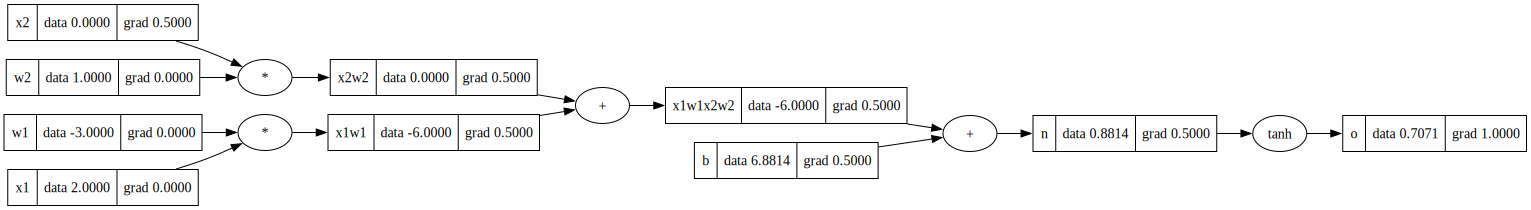

In [408]:
draw_dot(o)

In [410]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

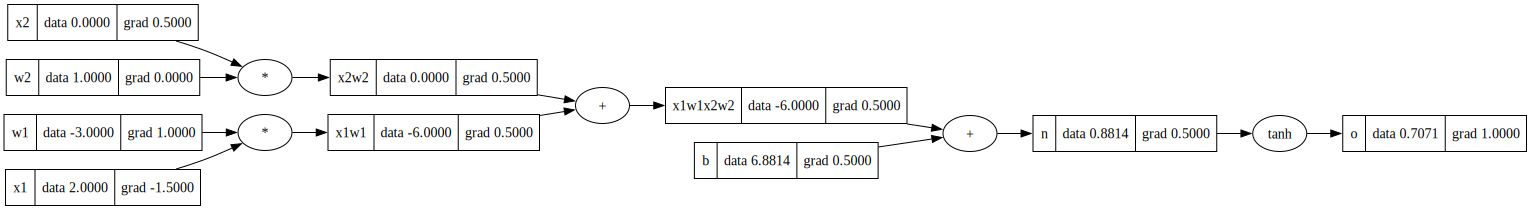

In [412]:
draw_dot(o)

## Automating backpropergation in the original Value class

In [444]:
o.grad = 1

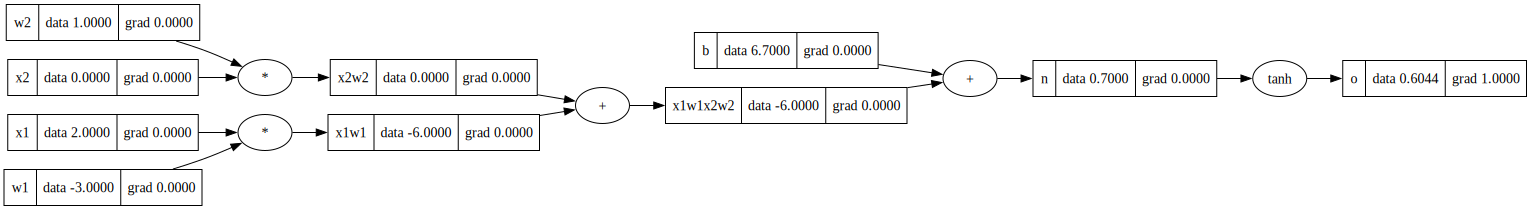

In [446]:
draw_dot(o)

In [448]:
o._backward()

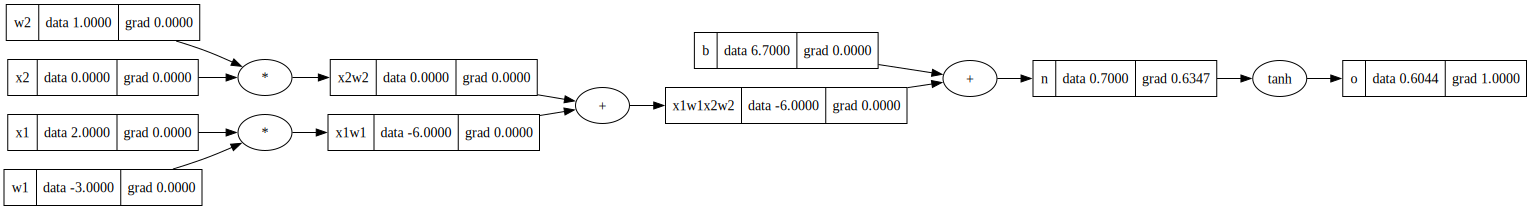

In [450]:
draw_dot(o)

In [426]:
n._backward()

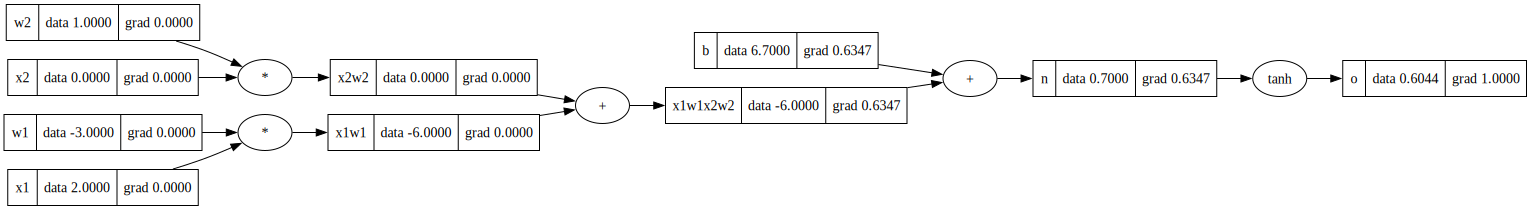

In [428]:
draw_dot(o)

In [430]:
x1w1x2w2._backward()

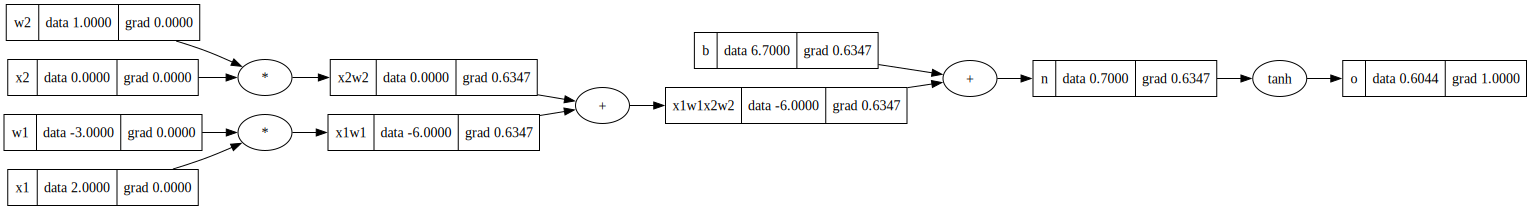

In [432]:
draw_dot(o)

In [434]:
x2w2._backward()

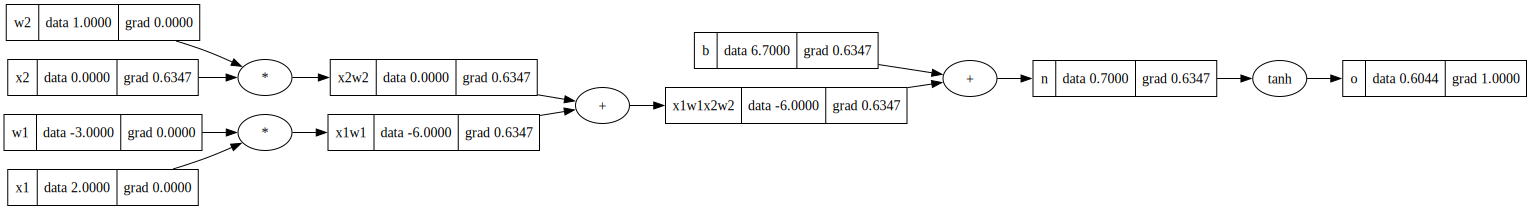

In [436]:
draw_dot(o)

In [438]:
x1w1._backward()

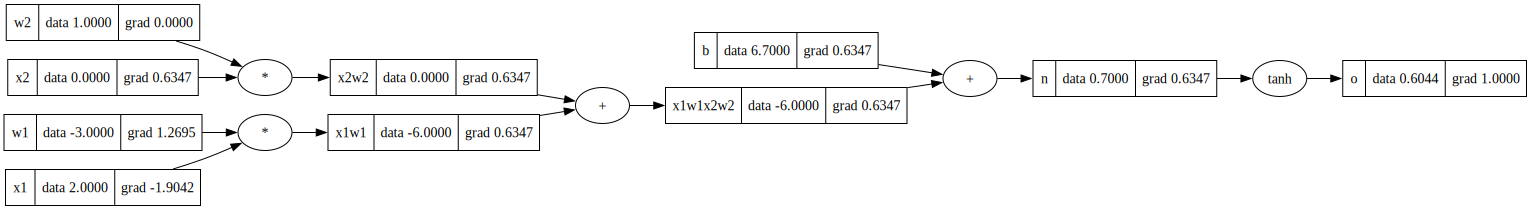

In [440]:
draw_dot(o)

In [455]:
## Topological sort to automatically set all the grads
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.7),
 Value(data=0.7000000000000002),
 Value(data=0.6043677771171636)]